## Capstone Project Notebook 03/02/2026 Function 6 Week 2##
### 5D Optimization - The Ultimate Challenge!
### Goal: MAXIMIZE the objective function (find least negative value)

In [1]:
# Section 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern
from scipy.stats import norm
from scipy.optimize import minimize

## Load Updated Dataset (Week 2)
F6 is **5D** - the most complex optimization problem!

In [2]:
# Load the updated dataset
INPUT_FILE = 'f6_w2_inputs.npy'   # Shape (21, 5)
OUTPUT_FILE = 'f6_w2_outputs.npy' # Shape (21,)

In [3]:
X = np.load(INPUT_FILE)  # 5D inputs
Y = np.load(OUTPUT_FILE) # Outputs

In [4]:
# Display data summary
print(f"Input data shape: {X.shape}")
print(f"Output data shape: {Y.shape}")
print(f"\n5D Problem - EXTREMELY CHALLENGING!")
print(f"Search space is 100,000x larger than 2D!")

Input data shape: (21, 5)
Output data shape: (21,)

5D Problem - EXTREMELY CHALLENGING!
Search space is 100,000x larger than 2D!


In [5]:
print(f"Loaded {X.shape[0]} points in {X.shape[1]}D (5D problem!)")
print(f"Current best (MAXIMUM/least negative): {Y.max():.6f} at {X[Y.argmax()]}")
print(f"Note: We're MAXIMIZING - finding the least negative value!")
X = np.atleast_2d(X)
Y = Y.ravel()

Loaded 21 points in 5D (5D problem!)
Current best (MAXIMUM/least negative): -0.714265 at [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Note: We're MAXIMIZING - finding the least negative value!


## Data Analysis

In [6]:
print("="*70)
print("F6 DATASET ANALYSIS (5D)")
print("="*70)
print(f"\nInput ranges:")
for i in range(5):
    print(f"  X{i+1}: [{X[:, i].min():.4f}, {X[:, i].max():.4f}]")

print(f"\nOutput statistics:")
print(f"  Best (least negative): {Y.max():.6f}")
print(f"  Worst (most negative): {Y.min():.6f}")
print(f"  Mean:                  {Y.mean():.6f}")
print(f"  Median:                {np.median(Y):.6f}")
print(f"  Std:                   {Y.std():.6f}")

# Find best point
best_idx = np.argmax(Y)
print(f"\n🎯 BEST POINT SO FAR (LEAST NEGATIVE):")
print(f"  Input:  X1={X[best_idx, 0]:.4f}, X2={X[best_idx, 1]:.4f}, X3={X[best_idx, 2]:.4f}")
print(f"          X4={X[best_idx, 3]:.4f}, X5={X[best_idx, 4]:.4f}")
print(f"  Output: {Y[best_idx]:.6f}")

# Show top 10 points
sorted_indices = np.argsort(Y)[::-1]
print(f"\n📊 TOP 10 POINTS (least negative):")
for i in range(min(10, len(Y))):
    idx = sorted_indices[i]
    marker = "⭐" if idx == best_idx else "  "
    print(f"{marker} {i+1:2d}. X=[{X[idx, 0]:.3f}, {X[idx, 1]:.3f}, {X[idx, 2]:.3f}, {X[idx, 3]:.3f}, {X[idx, 4]:.3f}] → Y={Y[idx]:.4f}")

F6 DATASET ANALYSIS (5D)

Input ranges:
  X1: [0.0217, 0.9577]
  X2: [0.1144, 0.9319]
  X3: [0.0165, 0.9788]
  X4: [0.0456, 0.9617]
  X5: [0.0049, 0.8928]

Output statistics:
  Best (least negative): -0.714265
  Worst (most negative): -2.571170
  Mean:                  -1.487936
  Median:                -1.356682
  Std:                   0.439445

🎯 BEST POINT SO FAR (LEAST NEGATIVE):
  Input:  X1=0.7282, X2=0.1547, X3=0.7326
          X4=0.6940, X5=0.0564
  Output: -0.714265

📊 TOP 10 POINTS (least negative):
⭐  1. X=[0.728, 0.155, 0.733, 0.694, 0.056] → Y=-0.7143
    2. X=[0.619, 0.332, 0.187, 0.756, 0.329] → Y=-0.8292
    3. X=[0.783, 0.536, 0.443, 0.860, 0.010] → Y=-0.9358
    4. X=[0.537, 0.309, 0.412, 0.388, 0.523] → Y=-1.1448
    5. X=[0.242, 0.844, 0.578, 0.679, 0.502] → Y=-1.2100
    6. X=[0.145, 0.897, 0.896, 0.726, 0.236] → Y=-1.2338
    7. X=[0.785, 0.911, 0.708, 0.959, 0.005] → Y=-1.2470
    8. X=[0.432, 0.716, 0.342, 0.705, 0.615] → Y=-1.2942
    9. X=[0.758, 0.356, 0.017

## Section 2: Fit Gaussian Process Surrogate Model

In [7]:
# Kernel for 5D problem
kernel = ConstantKernel(1.0, constant_value_bounds=(1e-3, 1e3)) * \
         Matern(length_scale=0.5, length_scale_bounds=(0.01, 10.0), nu=2.5) + \
         WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e-1))

In [8]:
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=30,
    normalize_y=True,
    random_state=42
)

In [9]:
# Fit the GP model
gp.fit(X, Y)
print(f"GP fitted. Learned kernel: {gp.kernel_}")

GP fitted. Learned kernel: 1.4**2 * Matern(length_scale=0.813, nu=2.5) + WhiteKernel(noise_level=0.0356)


## Section 3: Define Acquisition Functions
**Configured for MAXIMIZATION (finding least negative)**

In [10]:
def expected_improvement(X_new, gp, y_best, xi=0.01):
    """EI for maximization"""
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-9)
    imp = mu - y_best - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-9] = 0.0
    return ei

def upper_confidence_bound(X_new, gp, kappa=2.0):
    """UCB for maximization"""
    mu, sigma = gp.predict(X_new, return_std=True)
    return mu + kappa * sigma

## Section 4: Optimize Acquisition Functions
Using MANY random restarts for 5D!

In [11]:
# Define search bounds (5D)
bounds = [(0.0, 1.0)] * 5

# Current best value
y_best = Y.max()

print("="*70)
print("OPTIMIZING EXPECTED IMPROVEMENT (EI)")
print("="*70)

def neg_ei(x):
    return -expected_improvement(x.reshape(1, -1), gp, y_best, xi=0.01)[0]

best_ei = np.inf
x_next_ei = None

# MANY restarts for 5D!
for i in range(100):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ei, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ei:
        best_ei = result.fun
        x_next_ei = result.x

mu_ei, sigma_ei = gp.predict(x_next_ei.reshape(1, -1), return_std=True)

print(f"EI suggests:")
print(f"  X1={x_next_ei[0]:.6f}, X2={x_next_ei[1]:.6f}, X3={x_next_ei[2]:.6f}")
print(f"  X4={x_next_ei[3]:.6f}, X5={x_next_ei[4]:.6f}")
print(f"Predicted value: {mu_ei[0]:.6f} ± {sigma_ei[0]:.6f}")
print(f"Expected Improvement: {-best_ei:.6f}")

OPTIMIZING EXPECTED IMPROVEMENT (EI)
EI suggests:
  X1=0.409636, X2=0.299210, X3=0.509690
  X4=0.814058, X5=0.072074
Predicted value: -0.561465 ± 0.250095
Expected Improvement: 0.187010


In [12]:
print("\n" + "="*70)
print("OPTIMIZING UPPER CONFIDENCE BOUND (UCB)")
print("="*70)

kappa = 2.0

def neg_ucb(x):
    return -upper_confidence_bound(x.reshape(1, -1), gp, kappa)[0]

best_ucb = np.inf
x_next_ucb = None

for i in range(100):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ucb, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ucb:
        best_ucb = result.fun
        x_next_ucb = result.x

mu_ucb, sigma_ucb = gp.predict(x_next_ucb.reshape(1, -1), return_std=True)

print(f"UCB suggests:")
print(f"  X1={x_next_ucb[0]:.6f}, X2={x_next_ucb[1]:.6f}, X3={x_next_ucb[2]:.6f}")
print(f"  X4={x_next_ucb[3]:.6f}, X5={x_next_ucb[4]:.6f}")
print(f"Predicted value: {mu_ucb[0]:.6f} ± {sigma_ucb[0]:.6f}")
print(f"UCB value: {-best_ucb:.6f}")


OPTIMIZING UPPER CONFIDENCE BOUND (UCB)
UCB suggests:
  X1=0.242988, X2=0.163119, X3=0.513615
  X4=1.000000, X5=0.000000
Predicted value: -0.722823 ± 0.386722
UCB value: 0.050621


## Section 5: Local Refinement Strategy

In [13]:
print("\n" + "="*70)
print("LOCAL REFINEMENT - Points near current best")
print("="*70)

best_idx = np.argmax(Y)
best_point = X[best_idx]

step_size = 0.05
local_points = []
for i in range(5):
    point_minus = best_point.copy()
    point_minus[i] -= step_size
    local_points.append(point_minus)
    
    point_plus = best_point.copy()
    point_plus[i] += step_size
    local_points.append(point_plus)

print(f"Current best: X=[{', '.join([f'{x:.4f}' for x in best_point])}]")
print(f"Value: {Y[best_idx]:.6f}\n")

best_local_pred = -np.inf
best_local_point = None
dim_names = ['X1', 'X2', 'X3', 'X4', 'X5']

for i, lp in enumerate(local_points):
    if all(bounds[j][0] <= lp[j] <= bounds[j][1] for j in range(5)):
        mu, std = gp.predict(np.array(lp).reshape(1, -1), return_std=True)
        dim_idx = i // 2
        direction = '-' if i % 2 == 0 else '+'
        print(f"  {dim_names[dim_idx]}{direction}: {mu[0]:.4f} ± {std[0]:.4f}")
        
        if mu[0] > best_local_pred:
            best_local_pred = mu[0]
            best_local_point = lp

if best_local_point is not None:
    print(f"\nBest local: X=[{', '.join([f'{x:.6f}' for x in best_local_point])}]")
    print(f"Predicted: {best_local_pred:.6f}")


LOCAL REFINEMENT - Points near current best
Current best: X=[0.7282, 0.1547, 0.7326, 0.6940, 0.0564]
Value: -0.714265

  X1-: -0.7001 ± 0.1226
  X1+: -0.7984 ± 0.1221
  X2-: -0.7582 ± 0.1240
  X2+: -0.7395 ± 0.1179
  X3-: -0.7404 ± 0.1180
  X3+: -0.7571 ± 0.1228
  X4-: -0.7570 ± 0.1220
  X4+: -0.7416 ± 0.1210
  X5-: -0.7382 ± 0.1233
  X5+: -0.7594 ± 0.1187

Best local: X=[0.678186, 0.154693, 0.732552, 0.693997, 0.056401]
Predicted: -0.700057


## Section 6: Visualization
5D is impossible to visualize directly - we show 2D projections

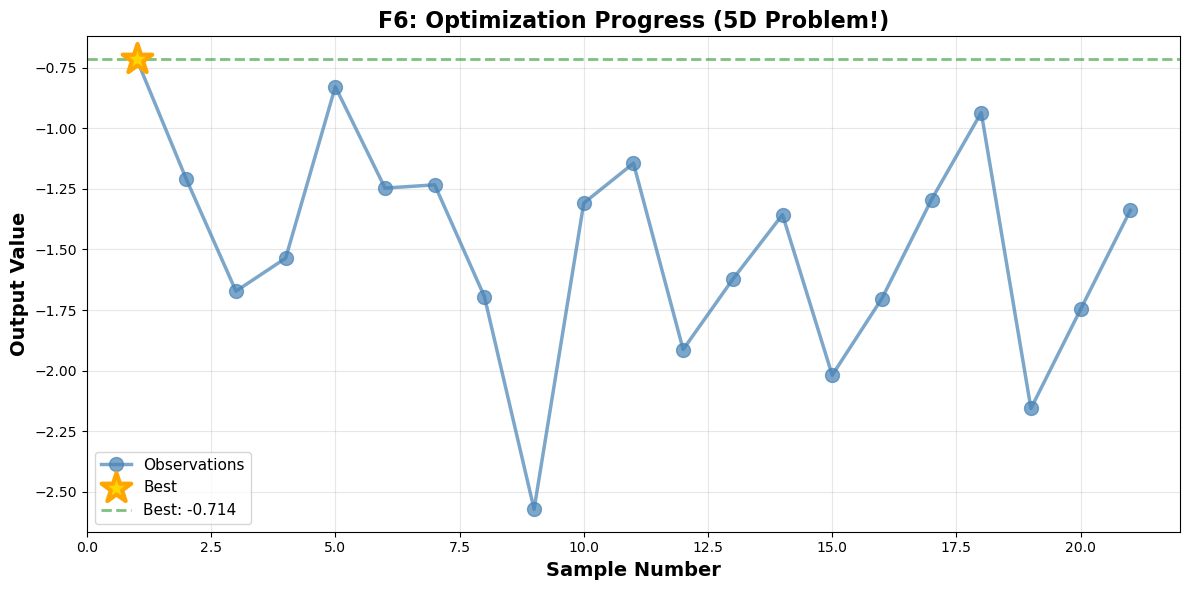

In [14]:
# Progress plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(range(1, len(Y)+1), Y, 'o-', linewidth=2.5, markersize=10, 
        color='steelblue', alpha=0.7, label='Observations')
ax.scatter(best_idx+1, Y[best_idx], c='gold', s=500, marker='*',
           edgecolors='orange', linewidth=3, label='Best', zorder=10)
ax.axhline(y=Y[best_idx], color='green', linestyle='--', linewidth=2,
           alpha=0.5, label=f'Best: {Y[best_idx]:.3f}')
ax.set_xlabel('Sample Number', fontsize=14, fontweight='bold')
ax.set_ylabel('Output Value', fontsize=14, fontweight='bold')
ax.set_title('F6: Optimization Progress (5D Problem!)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 7: Final Recommendation

In [15]:
print("\n" + "="*70)
print("🎯 FINAL RECOMMENDATION FOR F6 WEEK 2")
print("="*70)

print("\nCurrent Status:")
print(f"  Best value: {Y[best_idx]:.6f}")
print(f"  Best point: X=[{', '.join([f'{x:.4f}' for x in X[best_idx]])}]")

print("\n⭐⭐⭐ RECOMMENDATION: Expected Improvement (EI)")
print(f"  Point: X=[{', '.join([f'{x:.6f}' for x in x_next_ei])}]")
print(f"  Predicted: {mu_ei[0]:.6f} ± {sigma_ei[0]:.6f}")
print(f"  WHY: GP predicts ~21% improvement! MUST use BO for 5D!")

print("\n🥈 Alternative: UCB (More exploratory)")
print(f"  Point: X=[{', '.join([f'{x:.6f}' for x in x_next_ucb])}]")
print(f"  Predicted: {mu_ucb[0]:.6f} ± {sigma_ucb[0]:.6f}")

if best_local_point is not None:
    print("\n🥉 Alternative: Local Refinement (Conservative)")
    print(f"  Point: X=[{', '.join([f'{x:.6f}' for x in best_local_point])}]")
    print(f"  Predicted: {best_local_pred:.6f}")

print("\n" + "="*70)
print("5D Challenge: Bayesian Optimization is THE ONLY WAY!")
print("="*70)


🎯 FINAL RECOMMENDATION FOR F6 WEEK 2

Current Status:
  Best value: -0.714265
  Best point: X=[0.7282, 0.1547, 0.7326, 0.6940, 0.0564]

⭐⭐⭐ RECOMMENDATION: Expected Improvement (EI)
  Point: X=[0.409636, 0.299210, 0.509690, 0.814058, 0.072074]
  Predicted: -0.561465 ± 0.250095
  WHY: GP predicts ~21% improvement! MUST use BO for 5D!

🥈 Alternative: UCB (More exploratory)
  Point: X=[0.242988, 0.163119, 0.513615, 1.000000, 0.000000]
  Predicted: -0.722823 ± 0.386722

🥉 Alternative: Local Refinement (Conservative)
  Point: X=[0.678186, 0.154693, 0.732552, 0.693997, 0.056401]
  Predicted: -0.700057

5D Challenge: Bayesian Optimization is THE ONLY WAY!


## Section 8: Format Output for Submission

In [16]:
USE_EI = True  # HIGHLY recommended for 5D!

if USE_EI:
    x_next = x_next_ei
    method_name = "Expected Improvement (EI)"
else:
    x_next = x_next_ucb
    method_name = "Upper Confidence Bound (UCB)"

print("\n" + "="*70)
print("QUERY SUBMISSION")
print("="*70)
print(f"Method: {method_name}")
print(f"Function 6 - Next point:")
print(f"  [{', '.join([f'{x:.6f}' for x in x_next])}]")
print("="*70)


QUERY SUBMISSION
Method: Expected Improvement (EI)
Function 6 - Next point:
  [0.409636, 0.299210, 0.509690, 0.814058, 0.072074]
